<h2>Fastai on covid-19 dataset</h2> 


### Step 1: Installing latest version of torch


In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #restart runtime after its done executing only if asked for.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 753.4 MB 6.8 kB/s 
     |████████████████████████████████| 4.0 MB 61.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.


## In case the system asks you to Restart Runtime, just execute.

### Step 2: Set up google colab for fast.ai

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


### Step 3: Import required libraries for image classification problem


In [3]:
from fastai.vision import *

### Step 4: Mounting Google drive

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Step 5: Setting path

In [5]:
%cd /content/gdrive/MyDrive
path=Path('RWDS/Covid-19.zip/Covid-19/train') #set your path based on where you store.

/content/gdrive/MyDrive


In [6]:
!ls {path} #printing list of files/folder in the path

Covid  export.pkl  models  Normal  Seasonal_flu


### Step 6: Image Preprocessing 


Verifying for corrupt Images in the dataset 

In [7]:
classes = ['Covid','Normal','Seasonal_flu'] ##Classification problem 

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500 )

Covid


Normal


Seasonal_flu


Dataset needs to be converted into a DataBunch object, and in the case of the computer vision data - specifically into an ImageDataBunch subclass. Parameter 1 is the path of the folder, train='.', . means the files that are present the forder are all train data with validation data of 20 percent. 

Here is the link for get_transform
https://docs.fast.ai/vision.transform.html#get_transforms

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

##It is always a good practice to check whether the data is read correctly or not.

In [10]:
data.classes

['Covid', 'Normal', 'Seasonal_flu']

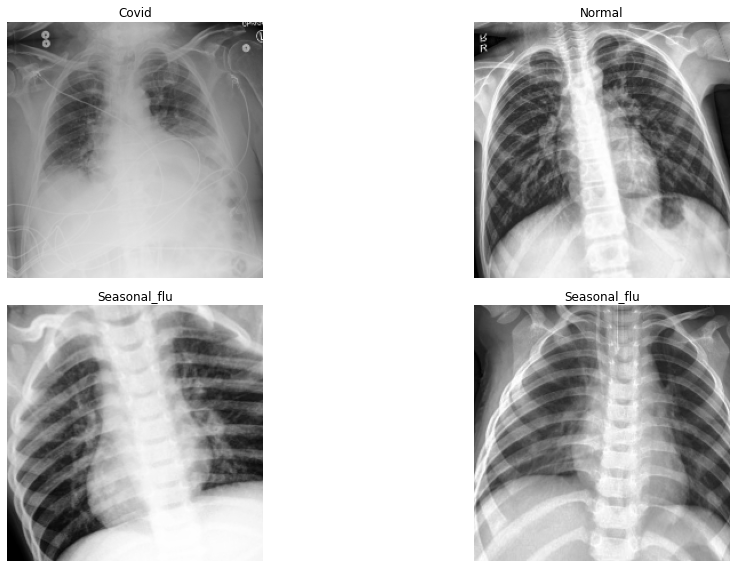

In [11]:
data.show_batch(rows=2, figsize=(16,8))

### Step 7. Train model.  

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate) #CNN:  Convolution neural net

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
learn.fit_one_cycle(10) 

epoch,train_loss,valid_loss,error_rate,time
0,1.547844,2.681197,0.703125,00:08
1,1.023843,0.880580,0.234375,00:06
2,0.773350,1.071325,0.234375,00:06
3,0.615437,0.712868,0.140625,00:06
4,0.529022,0.240076,0.125000,00:06
5,0.468810,0.152736,0.078125,00:06
6,0.415309,0.221726,0.078125,00:06
7,0.362199,0.256942,0.062500,00:06
8,0.321362,0.346186,0.062500,00:06
9,0.290867,0.359150,0.062500,00:06


In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze() #Train weights at all the layers of the network

In [16]:
learn.lr_find() #We can either manually supply start and end learning rate or it will take values between 1e-07 to 1e01 by default

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


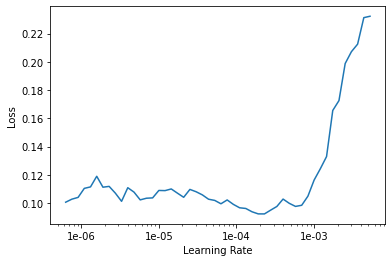

In [17]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4)) #The idea of decreasing the learning rate as you train is called learning rate annealing

epoch,train_loss,valid_loss,error_rate,time
0,0.162360,0.352052,0.078125,00:07
1,0.139780,0.296717,0.093750,00:07
2,0.119660,0.342506,0.078125,00:07
3,0.108527,0.345455,0.078125,00:07
4,0.113564,0.329962,0.062500,00:07
5,0.101668,0.291828,0.046875,00:07
6,0.089491,0.297839,0.046875,00:07
7,0.078460,0.306508,0.046875,00:07
8,0.074201,0.304559,0.031250,00:07
9,0.071488,0.323589,0.031250,00:07


In [19]:
learn.save('stage-2')

### Step 8. Interpret the result

In [20]:
learn.load('stage-2');

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

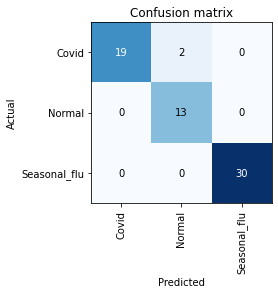

In [22]:
interp.plot_confusion_matrix() #Confusion matrix is where actual results are in rows and predicted are in columns

In [23]:
from fastai.widgets import ClassConfusion

In [24]:
ClassConfusion(interp,classes)

Please enter a value for `k`, or the top images you will see: 2


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


<Figure size 432x288 with 0 Axes>

### Step 9. Predict a new image for the class it belongs to

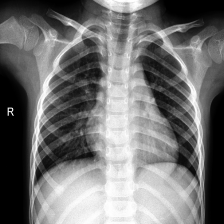

In [28]:
path=Path('RWDS/Covid-19.zip/Covid-19/test')
img = open_image(path/'test1.jpeg')
img.resize(torch.Size([img.shape[0],224,224]))

In [30]:
learn.export()
path=Path('RWDS/Covid-19.zip/Covid-19/train')

learn = load_learner(path)

In [31]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'Normal'